# EMRI Waveforms in Fourier Domain
Here we present the usage of the EMRI Waveforms in Fourier Domain. Currently we implemented the Fourier Domain Waveform only for the Schawrzchild case.

In [1]:
import sys, time, h5py
import numpy as np
import matplotlib.pyplot as plt
# import or install these packages for the data anlysis of the resultss
sys.path.append("../LISAanalysistools/")
sys.path.append("../Eryn/")

import corner
from lisatools.sampling.likelihood import Likelihood
from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.utility import get_mu_at_t
from few.utils.constants import *
from few.utils.utility import omp_set_num_threads
omp_set_num_threads(8)

try:
    import cupy as xp
    # set GPU device
    xp.cuda.runtime.setDevice(3)
    use_gpu = True

except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    use_gpu = False

import warnings
warnings.filterwarnings("ignore")


few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd",odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True,odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]



In [2]:
# define the injection parameters
M = 1e6 # central object mass
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 20.0 # secondary object mass
p0 = 12.0 # initial semi-latus rectum
e0 = 0.35 # eccentricity
x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/5  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/4  # polar sky angle
phiS = np.pi/6  # azimuthal viewing angle
dist = 3.0  # distance
# initial phases
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

Tobs = 2.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,0,2)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
    "mode_selection" : mode_selection,
#     "eps": eps
}

emri_injection_params = [
                            M,  
                            mu,
                            a, 
                            p0, 
                            e0, 
                            x0,
                            dist, 
                            qS,
                            phiS,
                            qK, 
                            phiK, 
                            Phi_phi0, 
                            Phi_theta0, 
                            Phi_r0
                        ]

## Comparison against the Time Domain Waveforms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


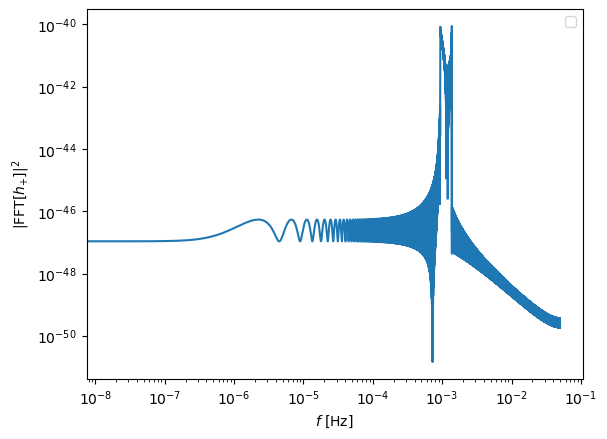

In [52]:
# create TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)

# take the FFT of the plus polarization and shift it
fft_TD = xp.fft.fftshift(xp.fft.fft(data_channels_td[0])) * dt
freq = xp.fft.fftshift(xp.fft.fftfreq(len(data_channels_td[0]) , dt))

# define the positive frequencies
positive_frequency_mask = (freq>=0.0)
    
plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2)
else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2)
plt.ylabel(r'$| {\rm FFT} [h_{+}]|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

In [53]:
# check that the frequency array is an odd number
len(freq)

6311631

In [54]:
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq

hf = few_gen(*emri_injection_params, **fd_kwargs)
# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# mask where the FD waveform is non zero
non_zero_mask = (xp.abs(hf[0])>1e-50)

# mismatch
fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask][non_zero_mask], hf[0][non_zero_mask], normalize=True, 
                **dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask][non_zero_mask])))
print("mismatch", Mism)



mismatch 0.005164822016916482
mismatch 0.002323719095630783


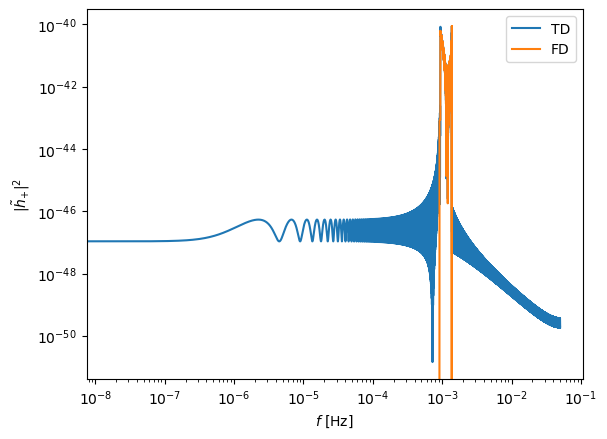

In [55]:
# FD plot
plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2,label='TD')
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,label='FD')
else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2,label='TD')
    plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,label='FD')
plt.ylabel(r'$| \tilde{h}_{+}|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

(10000000.0, 10005000.0)

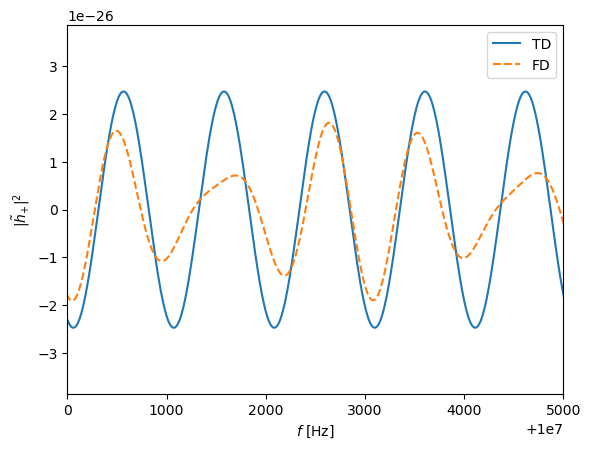

In [59]:
# TD plot
time = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = xp.fft.ifft(xp.append(hf[0],xp.flip(hf[0][1:] ))/dt)

plt.figure()
if use_gpu:
    plt.plot(time, data_channels_td[0].get(),label='TD')
    plt.plot(time, ifft_fd.get(),'--' ,label='FD')
else:
    plt.plot(time, data_channels_td[0],label='TD')
    plt.plot(time, ifft_fd,'--' ,label='FD')

plt.ylabel(r'$| \tilde{h}_{+}|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
t0 = 1e7
space_t = 5e3
plt.xlim([t0,t0+space_t])

## Frequency downsampling

In [7]:
# index of frequencies
lst_ind = list(range(len(freq)))
list_h = []
list_f = []

for ii in range(2,500):
    check = 1==np.sum(freq[lst_ind[0::ii]]==0.0)
    if check:
        print('--------------------------')
        print('skip every ',ii, 'th element')
        print('make sure there is the zero frequency ', check )
        print('number of frequencies', len(freq[lst_ind[0::ii]]))
        print('percentage of frequencies', len(freq[lst_ind[0::ii]])/len(freq))

        fd_kwargs = waveform_kwargs.copy()
        fd_kwargs['f_arr'] = freq[lst_ind[0::ii]]

        # generate wave
        tic = time.time()
        tmp_hf = few_gen(*emri_injection_params, **fd_kwargs)
        toc = time.time()
        print('timing ', toc - tic)

        f_arr = freq[lst_ind[0::ii]][freq[lst_ind[0::ii]]>=0.0]
        fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=f_arr)

        Mism = np.abs(1-inner_product(tmp_hf[0], hf[0][0::ii], normalize=True, **fd_inner_product_kwargs))
        print('mimsatch = ',Mism)



--------------------------
skip every  5 th element
make sure there is the zero frequency  True
number of frequencies 1262327
percentage of frequencies 0.2000001267501221
timing  0.17879939079284668
mimsatch =  0.0
--------------------------
skip every  13 th element
make sure there is the zero frequency  True
number of frequencies 485511
percentage of frequencies 0.07692322317321783
timing  0.07882833480834961
mimsatch =  0.0
--------------------------
skip every  47 th element
make sure there is the zero frequency  True
number of frequencies 134291
percentage of frequencies 0.02127675081131961
timing  0.06297945976257324
mimsatch =  0.0
--------------------------
skip every  65 th element
make sure there is the zero frequency  True
number of frequencies 97103
percentage of frequencies 0.015384771384765681
timing  0.05976605415344238
mimsatch =  0.0
--------------------------
skip every  235 th element
make sure there is the zero frequency  True
number of frequencies 26859
percentage 

## Mass invariance

In [8]:
list_h = []
list_f = []
T = 1.0
dt = 10.0
Mvec = 10**np.linspace(5.0,6.5,num=5)
fd_kwargs = waveform_kwargs.copy()

for M in Mvec:

    # fix mass ratio
    mu = 1e-5*M

    # rescale time
    Tnew = T*(M/1e6)
    
    # generate wave
    list_h.append(
        few_gen(M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,T=T,dt=dt,mode_selection=[(2,2,0)])
    )

    # adimensionless frequency
    list_f.append(few_gen.waveform_generator.create_waveform.frequency * M * MTSUN_SI )
    

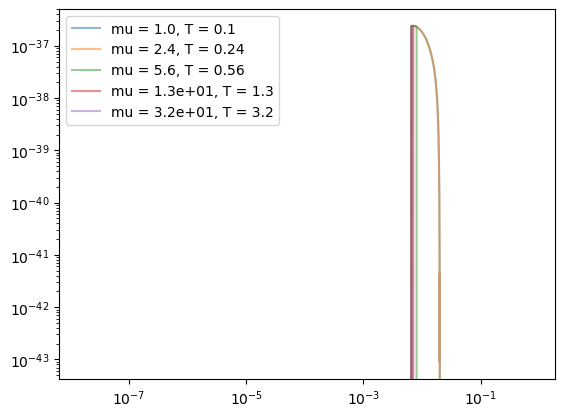

In [9]:
plt.figure()

for ii in range(len(Mvec)):
    Tnew = T * Mvec[ii] / 1e6
    tmp_mu = 1e-5 * Mvec[ii]
    
    ff = list_f[ii].get()
    ff = ff[ff>=0.0]
    h2 = np.abs(list_h[ii][0].get() / (tmp_mu * Tnew) )**2 
    
    plt.loglog(ff, h2, label = f'mu = {tmp_mu:.2}, T = {Tnew:.2}',alpha=0.5)

plt.legend()
plt.show()

## Speed analysis

In [37]:
import glob
# files = sorted(glob.glob('*T4.05*_.h5'))
# files = sorted(glob.glob('*seed2601996_dt8*_.h5'))
# files = sorted(glob.glob('*T4.05_seed2601996_dt5.0*_.h5'))
files = sorted(glob.glob('*seed2601996_dt5.0*_.h5'))

In [38]:
speed_up_factor = []
injection_pars = []
dt_T_eps = []
mismatch = []

for ff in files:
    # ff = files[0]
    dset = h5py.File(ff,'r')
    speed_up_factor.append(dset['timing_td'][...]/dset['timing_fd'][...])
    injection_pars.append(dset['list_injections'][...])
    mismatch.append(np.log10(dset['mismatch'][...]))
    dt_T_eps.append([dset['dt'][...], dset['T'][...], dset['eps'][...] ])
    dset.close()

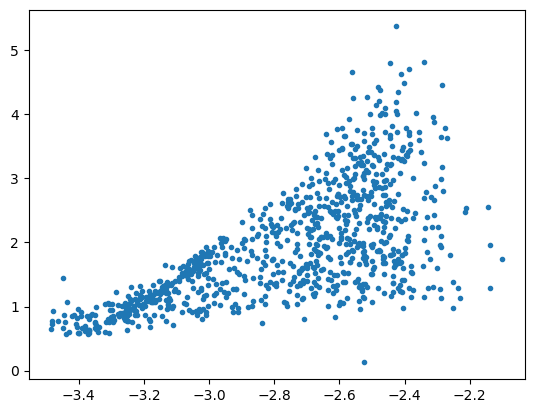

In [45]:
plt.plot(mismatch[0],speed_up_factor[0],'.')

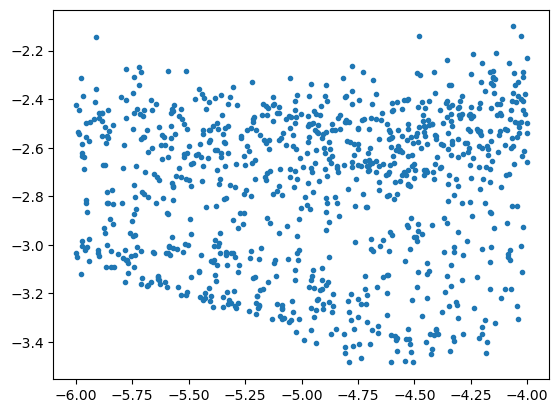

In [49]:
ii = 0
plt.plot(np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0]),mismatch[ii],'.')

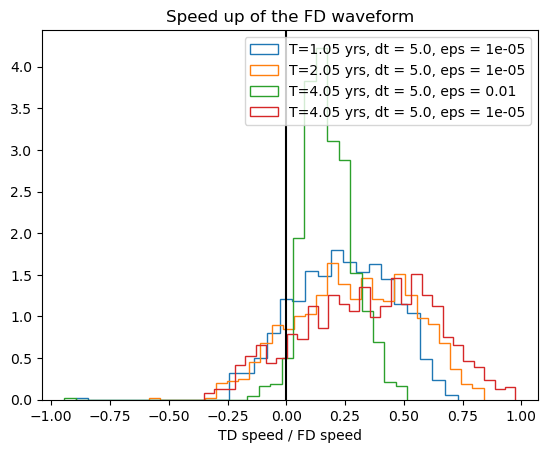

In [52]:
plt.figure()
plt.title(f'Speed up of the FD waveform')
[plt.hist(np.log10(speed),histtype='step', label=f'T={el[1]} yrs, dt = {el[0]}, eps = {el[2]}',density=True,bins=30) for speed,el in zip(speed_up_factor,dt_T_eps)]
plt.xlabel('TD speed / FD speed')
plt.legend()

plt.axvline(0.0,color='k')
plt.show()

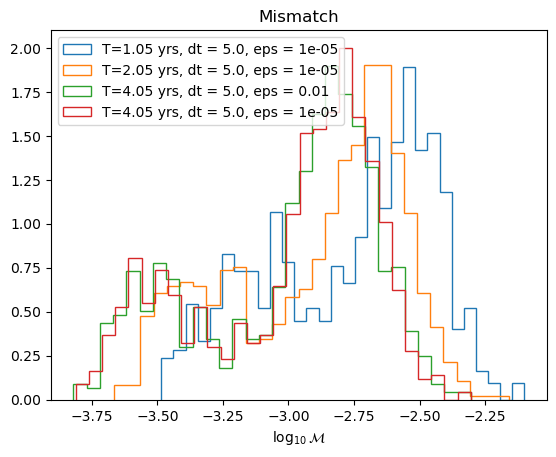

In [63]:
plt.figure()
plt.title(f'Mismatch')
[plt.hist(speed,histtype='step', label=f'T={el[1]} yrs, dt = {el[0]}, eps = {el[2]}',density=True,bins=30) for speed,el in zip(mismatch,dt_T_eps)]
plt.xlabel('$\log_{10}\mathcal{M}$')
plt.legend()
plt.show()

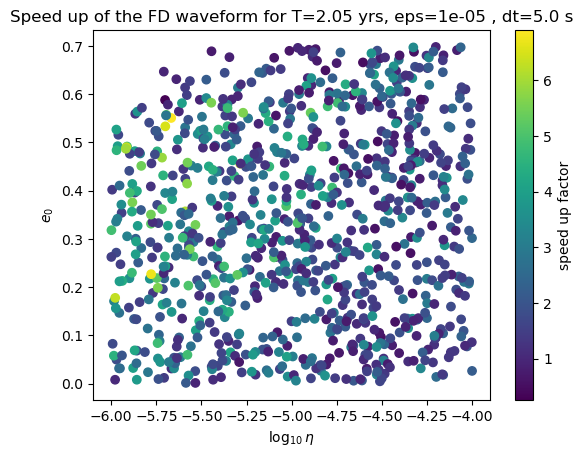

In [64]:
ii = 1
# Generate random data
x = np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0])
y = injection_pars[ii][:,4]
z = speed_up_factor[ii]

# Define color scheme
cmap = plt.get_cmap('viridis')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'Speed up of the FD waveform for T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')

plt.scatter(x, y, c=z, cmap=cmap)
plt.colorbar(label='speed up factor')

# Set axis labels and title
ax.set_xlabel('$\log_{10}\eta$')
ax.set_ylabel('$e_0$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
plt.show()

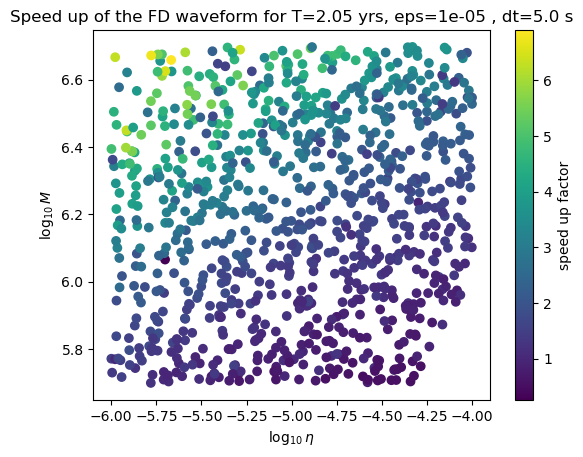

In [65]:
ii = 1
# Generate random data
x = np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0])
y = np.log10(injection_pars[ii][:,0])
z = speed_up_factor[ii]

# Define color scheme
cmap = plt.get_cmap('viridis')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'Speed up of the FD waveform for T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')
plt.scatter(x, y, c=z, cmap=cmap)
plt.colorbar(label='speed up factor')

# Set axis labels and title
ax.set_xlabel('$\log_{10} \eta$')
ax.set_ylabel('$\log_{10} M$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
plt.show()

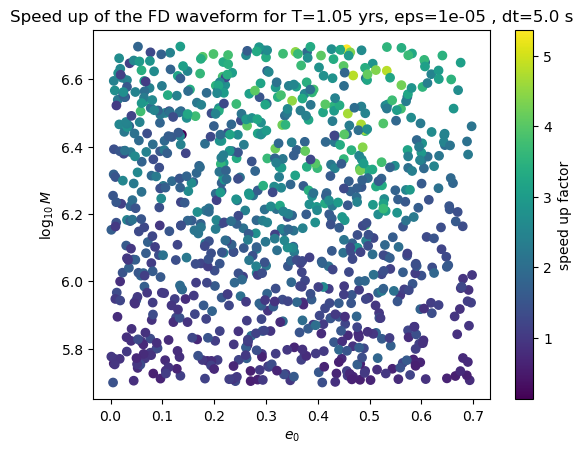

In [66]:
ii = 0
# Generate random data
x = injection_pars[ii][:,4]
y = np.log10(injection_pars[ii][:,0])
z = speed_up_factor[ii]

# Define color scheme
cmap = plt.get_cmap('viridis')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'Speed up of the FD waveform for T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')
plt.scatter(x, y, c=z, cmap=cmap)
plt.colorbar(label='speed up factor')

# Set axis labels and title
ax.set_xlabel('$e_0$')
ax.set_ylabel('$\log_{10} M$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
plt.show()

## Posterior comparison

In [3]:
from eryn.backends import HDFBackend
import h5py, glob

In [4]:
def get_autocorr_plot(to_check):
    n_dim  = to_check.shape[-1]
    plt.figure()
    for var in range(n_dim):
        y = to_check[:,:,var].T
        # Compute the estimators for a few different chain lengths
        N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
        gw2010 = np.empty(len(N))
        new = np.empty(len(N))
        for i, n in enumerate(N):
            gw2010[i] = autocorr_gw2010(y[:, :n])
            new[i] = autocorr_new(y[:, :n])

        # Plot the comparisons
        # plt.loglog(N, gw2010, "o-", label="G&W 2010")
        plt.loglog(N, new, "o-", label=f"new var{var}")

    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    # plt.axhline(true_tau, color="k", label="truth", zorder=-100)
    plt.xlabel("number of samples, $N$")
    plt.ylabel(r"$\tau$ estimates")
    plt.legend(fontsize=14);
    plt.show()



In [5]:
datasets = glob.glob('*downsample0*.h5')
datasets

['emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD0_templatefd.h5',
 'emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD0_templatetd.h5',
 'emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD1_templatefd.h5']

{'StretchMove_0': {'acceptance_fraction': array([[0.30802 , 0.331425, 0.342835, 0.292585, 0.34098 , 0.29542 ,
        0.338635, 0.334185, 0.336455, 0.33921 , 0.32496 , 0.312225,
        0.32632 , 0.31305 , 0.3404  , 0.34223 , 0.34344 , 0.331375,
        0.340925, 0.333765, 0.331505, 0.344245, 0.3365  , 0.33985 ,
        0.34366 , 0.33742 , 0.34982 , 0.325095, 0.340505, 0.329105,
        0.327995, 0.31959 ],
       [0.446175, 0.44193 , 0.44279 , 0.44816 , 0.44743 , 0.441805,
        0.4437  , 0.446005, 0.4461  , 0.44372 , 0.44278 , 0.444795,
        0.445685, 0.442455, 0.444725, 0.44481 , 0.441565, 0.446615,
        0.444205, 0.44666 , 0.45001 , 0.447745, 0.44446 , 0.448905,
        0.44582 , 0.445635, 0.447705, 0.445025, 0.448375, 0.44654 ,
        0.447425, 0.445505]])}}


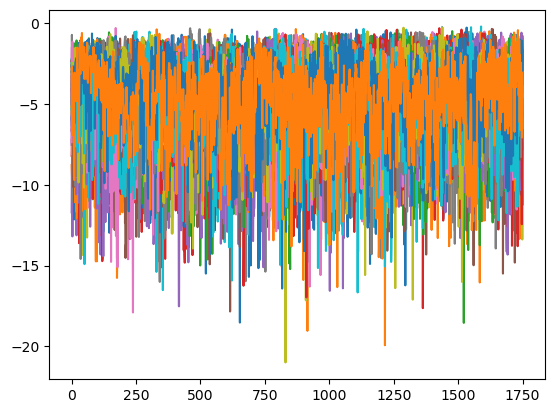

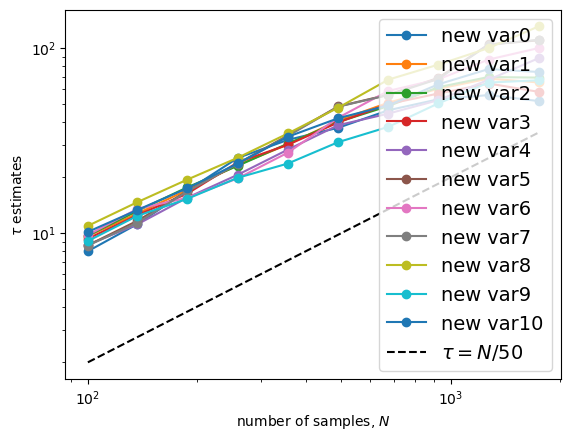

{'StretchMove_0': {'acceptance_fraction': array([[0.324615, 0.325805, 0.332765, 0.324545, 0.32646 , 0.338005,
        0.3212  , 0.34538 , 0.335445, 0.344645, 0.337215, 0.316905,
        0.33759 , 0.341095, 0.315905, 0.333385, 0.326755, 0.332295,
        0.326775, 0.308115, 0.322385, 0.330365, 0.33477 , 0.32639 ,
        0.323335, 0.338125, 0.32283 , 0.326085, 0.33209 , 0.32374 ,
        0.336335, 0.3288  ],
       [0.443925, 0.447545, 0.44464 , 0.446675, 0.4471  , 0.443725,
        0.44435 , 0.443505, 0.44714 , 0.44343 , 0.44374 , 0.44239 ,
        0.44631 , 0.445265, 0.44598 , 0.44459 , 0.4481  , 0.44139 ,
        0.444155, 0.447015, 0.44688 , 0.443505, 0.44556 , 0.44195 ,
        0.447185, 0.445845, 0.44553 , 0.44766 , 0.44556 , 0.444635,
        0.44515 , 0.4478  ]])}}


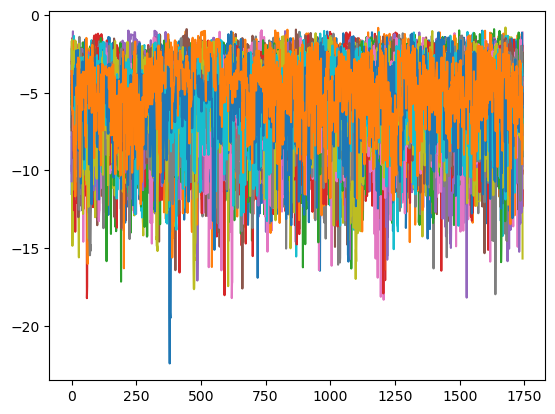

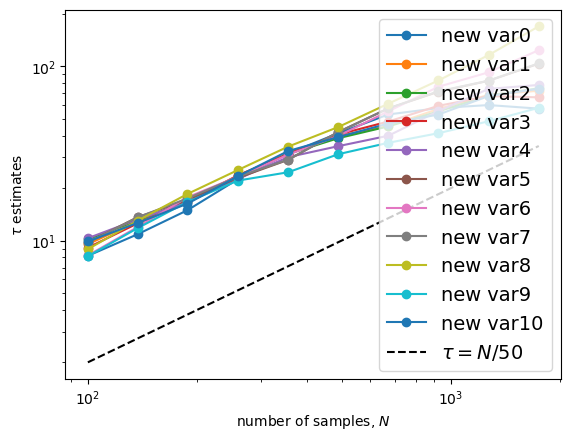

{'StretchMove_0': {'acceptance_fraction': array([[0.323145, 0.326275, 0.323995, 0.34138 , 0.343075, 0.32973 ,
        0.333755, 0.339125, 0.347815, 0.341055, 0.343875, 0.34567 ,
        0.334815, 0.328475, 0.341515, 0.323035, 0.32211 , 0.33346 ,
        0.33307 , 0.33308 , 0.3264  , 0.33037 , 0.34403 , 0.344965,
        0.32874 , 0.32471 , 0.321285, 0.321605, 0.338645, 0.325255,
        0.337715, 0.32121 ],
       [0.44422 , 0.444905, 0.44542 , 0.44293 , 0.444685, 0.448755,
        0.44539 , 0.446975, 0.448435, 0.444365, 0.444225, 0.445695,
        0.44248 , 0.44778 , 0.442745, 0.443745, 0.44396 , 0.443365,
        0.444035, 0.4486  , 0.444115, 0.44786 , 0.4478  , 0.444745,
        0.44492 , 0.44571 , 0.44529 , 0.446375, 0.443935, 0.441815,
        0.446825, 0.445135]])}}


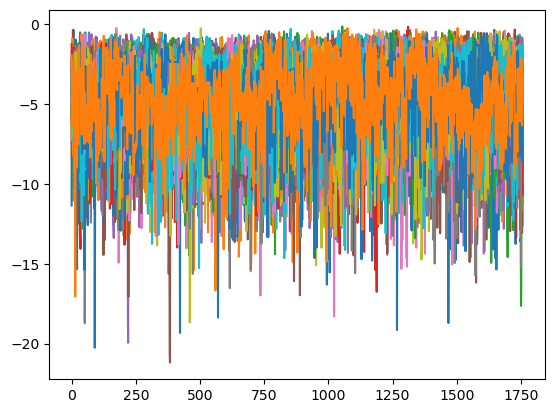

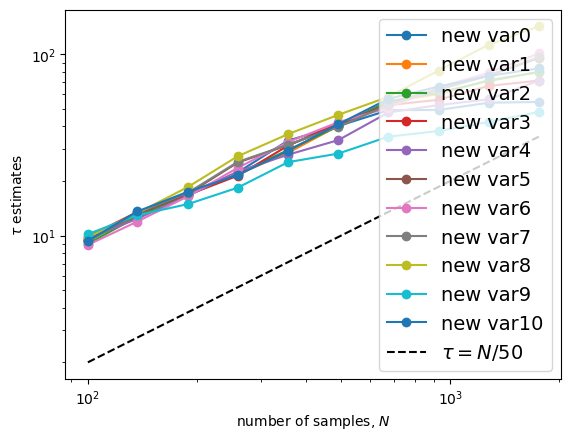

In [6]:
filename = 'emri_M1e+06_mu1e+01_p9.5_e0.35_T1.0_eps1e-05_seed2601996_injectFD1_templatefd.h5'
temp=0

samp_final = []
for filename in glob.glob('*downsample0*.h5'):
    file  = HDFBackend(filename)
    print(file.get_move_info())
    max_iter = file.iteration
    burn = int(max_iter*0.10)
    thin = 100
    ll = file.get_log_like(discard=burn, thin=thin )
    mask = np.arange(32)
    plt.figure()
    [plt.plot(ll[:,temp,walker],'-',label=f'{walker}') for walker in mask]
    plt.show()
    
    # get samples
    samp = file.get_chain(discard=burn, thin=thin)['emri'][:,temp,mask,...]
    get_autocorr_plot(samp[:,:,0,:])


    
    
    inds = file.get_inds(discard=burn, thin=thin)['emri']
    samp_final.append(samp[inds[:,temp,mask,...]])

In [11]:
M = 1e6
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 10.0
p0 = 10.438191628388795
e0 = 0.35
x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/3  # polar spin angle
phiK = np.pi/4  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/4  # azimuthal viewing angle
dist = 3.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

truths = [
            np.log(M),  
            np.log(mu/M),
            p0,
            e0,
            dist, 
            np.cos(qS),
            phiS,
            np.cos(qK), 
            phiK, 
            Phi_phi0, 
            Phi_r0
        ]

CORNER_KWARGS = dict(
    smooth=0.6,
    labels=[r'$\log M$', r'$\log \eta$', r'$p_0$', r'$e_0$', r'$D_L$',
            r'$\cos{\theta_K}$', r'$\phi_K$',
           r'$\cos{\theta_S}$', r'$\phi_S$',
           r'$\Phi_{\phi 0}$', r'$\Phi_{\theta 0}$',r'$\Phi_{r 0}$'
           ],
    bins=20,
    truths = truths,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
#     quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=True,
    max_n_ticks=7,
)
import matplotlib.lines as mlines

def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)


def overlaid_corner(samples_list, sample_labels, name_save=None, corn_kw=CORNER_KWARGS):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('tab10',)
    colors = [cmap(i) for i in range(n)]

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)

    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        weights=get_normalisation_weight(len(samples_list[0]), max_len),
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=15, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
    if name_save is not None:
        plt.savefig(name_save+".pdf")
    else:
        plt.show()


In [12]:
truths

[13.815510557964274,
 -11.512925464970229,
 10.438191628388795,
 0.35,
 3.0,
 0.5000000000000001,
 0.7853981633974483,
 0.5000000000000001,
 0.7853981633974483,
 1.0,
 3.0]

In [9]:
datasets

['emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD0_templatefd.h5',
 'emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD0_templatetd.h5',
 'emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD1_templatefd.h5']

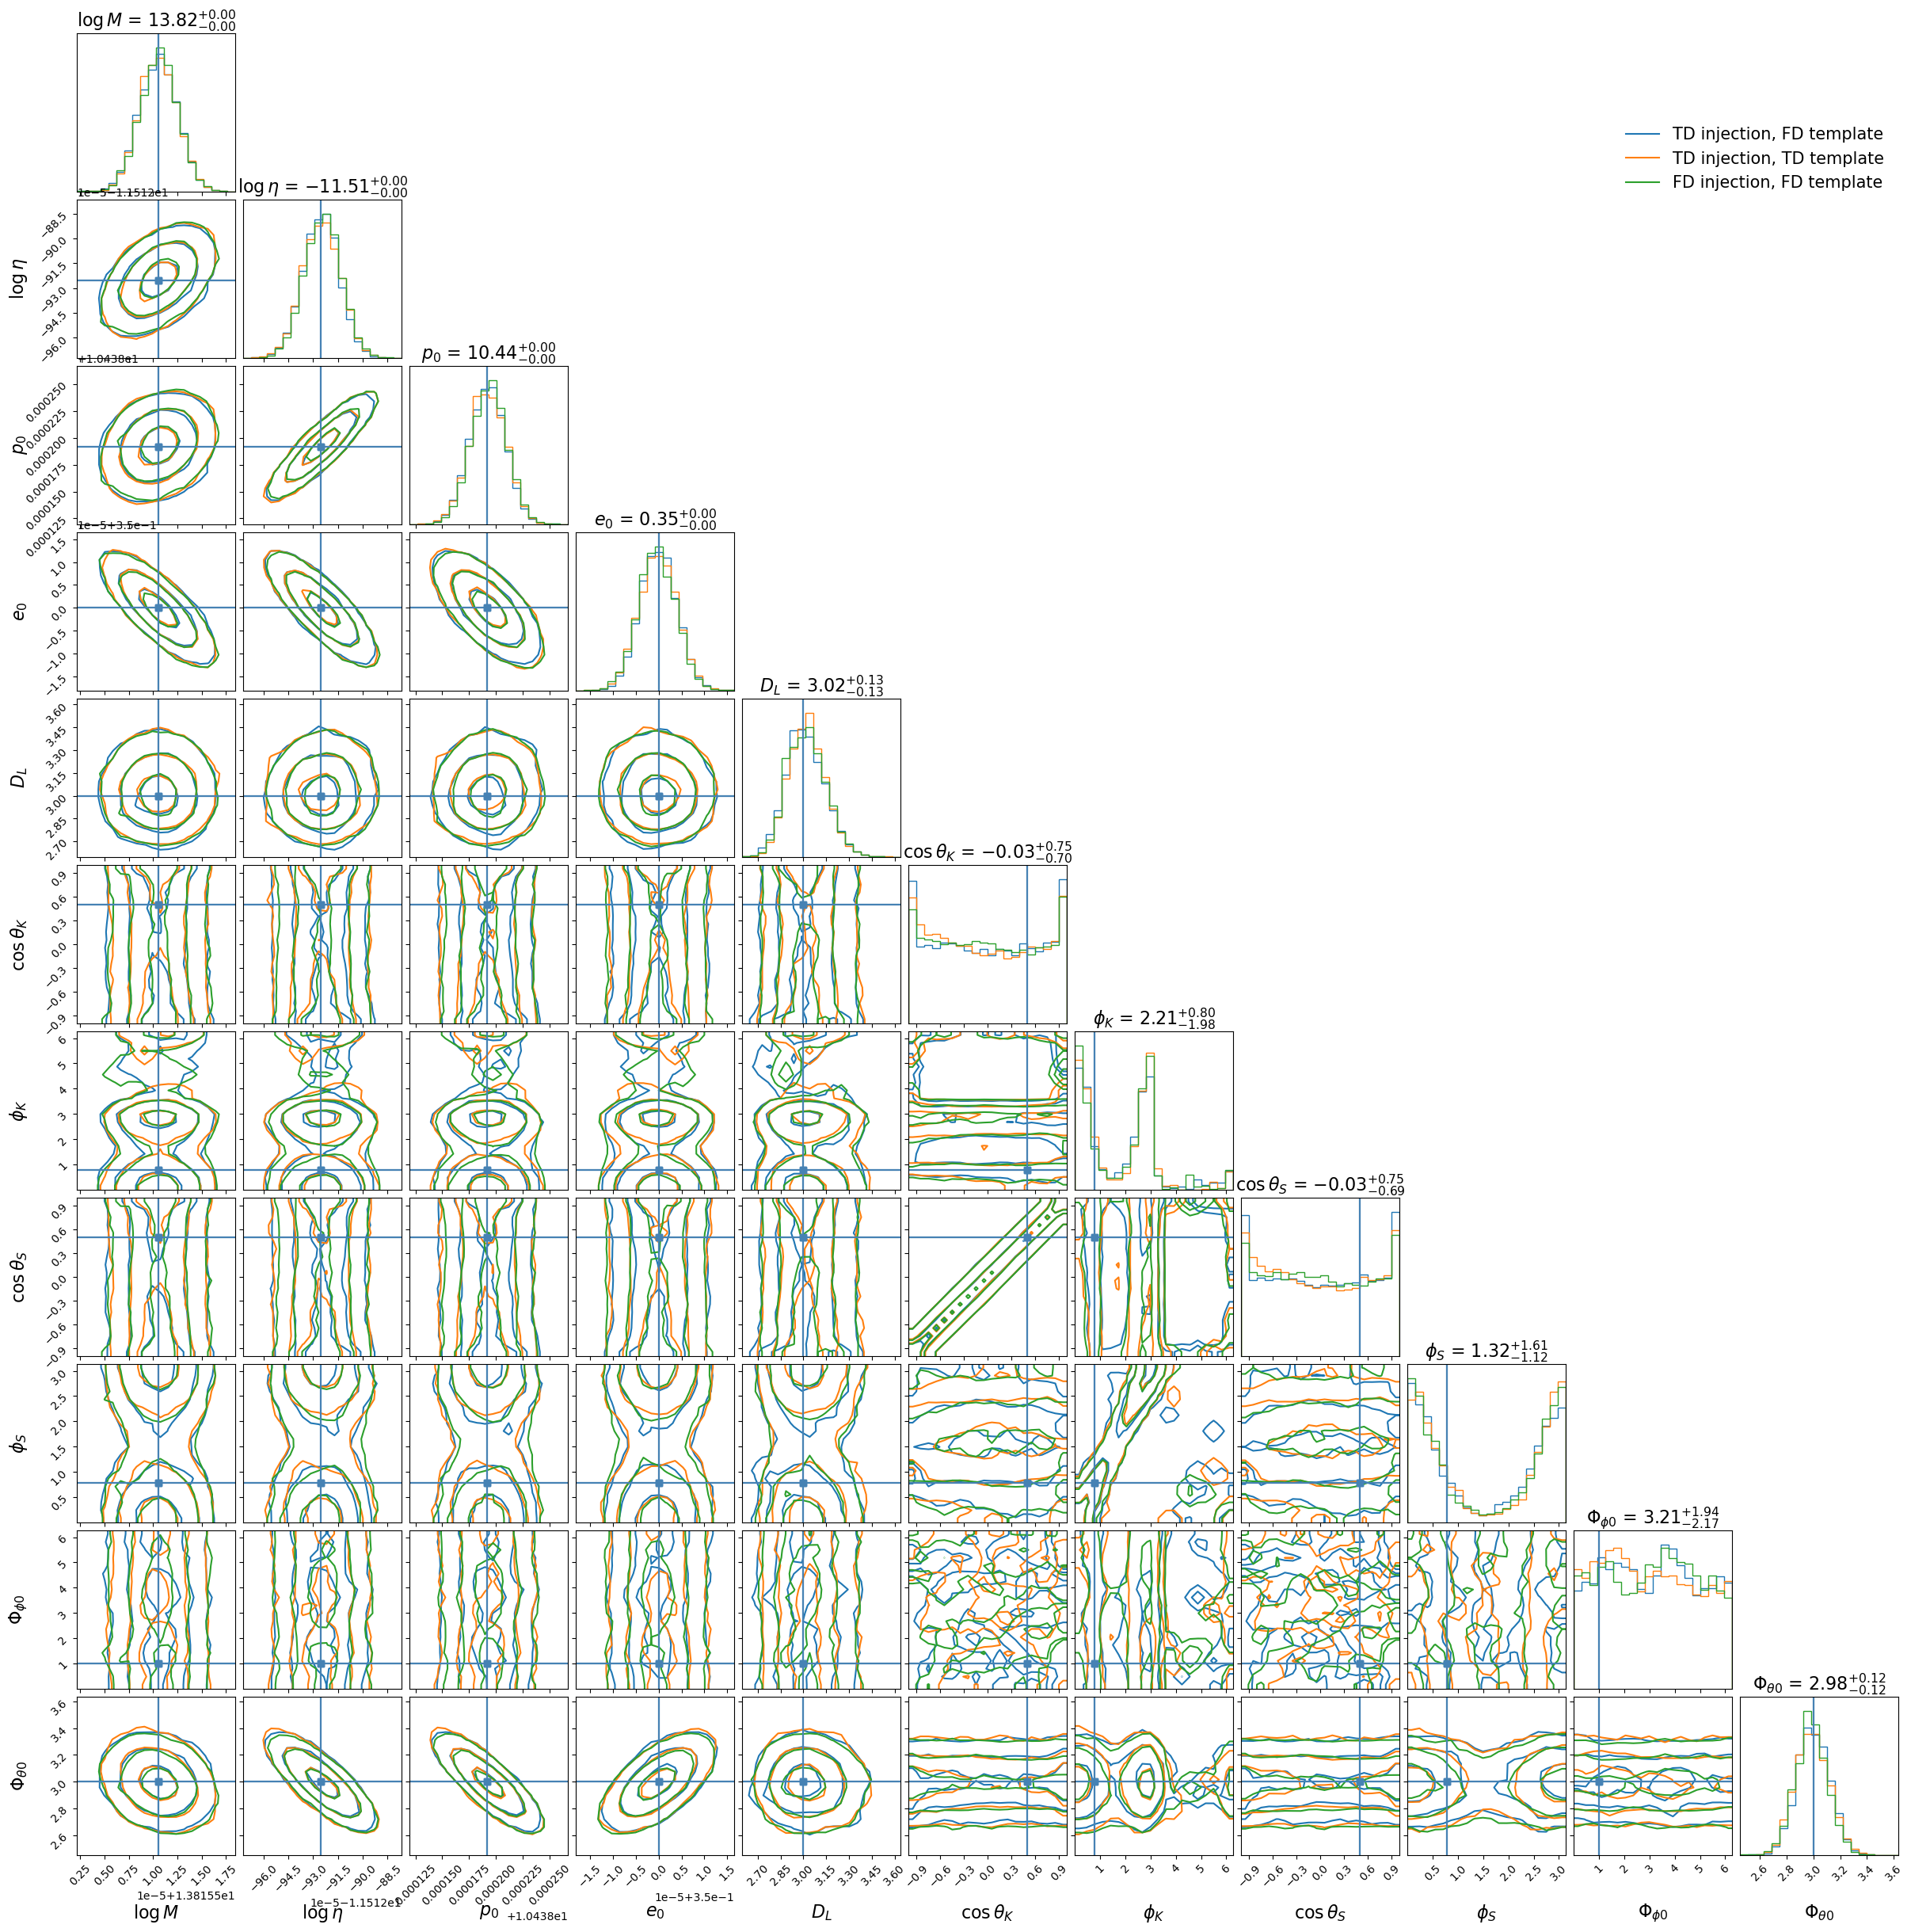

In [13]:
overlaid_corner(samp_final, ['TD injection, FD template', 'TD injection, TD template', 'FD injection, FD template'], name_save='posterior_comparison')

In [22]:
# np.save("covariance.npy",np.cov(samp_final[2].T))

In [19]:
np.save("samples_to_test",samp_final[0][-5000:])